In [42]:
# src/train.py  ← THIS IS THE ONLY CORRECT VERSION
import pandas as pd
import joblib
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

FEATURES = ['prev_close','prev_volume','rsi','macd','sma_20','sma_50','sma_200',
            'bb_upper','bb_lower','stoch_k','daily_return','volatility_30d']

def train_models():
    df = pd.read_csv("../data/processed/btcusdt_final.csv")
    df["future_return"] = df["close"].pct_change().shift(-1)
    df["label"] = df["future_return"].apply(lambda x: 2 if x > 0.02 else (0 if x < -0.02 else 1))
    df = df.dropna().reset_index(drop=True)

    X = df[FEATURES]
    y = df["label"]

    # THIS IS THE LINE THAT WAS MISSING IN YOUR VERSION
    weights = compute_class_weight('balanced', classes=np.array([0,1,2]), y=y)
    weight_list = weights.tolist()
    print("CLASS WEIGHTS APPLIED:", [f"{w:.2f}" for w in weight_list])   # ← YOU MUST SEE THIS

    split = int(len(df) * 0.85)
    X_train, y_train = X.iloc[:split], y.iloc[:split]

    models = {
        "catboost": CatBoostClassifier(
            iterations=2000, depth=6, learning_rate=0.03,
            class_weights=weight_list,      # ← THIS FIXES EVERYTHING
            verbose=100
        ),
        "lightgbm": LGBMClassifier(class_weight='balanced'),
        "xgboost": XGBClassifier(scale_pos_weight=weight_list[2], eval_metric="mlogloss"),
        "random_forest": RandomForestClassifier(class_weight='balanced', n_estimators=1000),
        "logistic": LogisticRegression(class_weight='balanced', max_iter=1000)
    }

    os.makedirs("../models", exist_ok=True)
    for name, model in models.items():
        print(f"\n=== TRAINING {name.upper()} ===")
        model.fit(X_train, y_train)
        joblib.dump(model, f"../models/{name}.pkl")
        print(f"→ {name}.pkl SAVED")

    print("\nALL MODELS RE-TRAINED WITH CLASS WEIGHTS — YOU ARE NOW FIXED!")

if __name__ == "__main__":
    train_models()

CLASS WEIGHTS APPLIED: ['2.26', '0.50', '1.80']

=== TRAINING CATBOOST ===
0:	learn: 1.0961649	total: 12.6ms	remaining: 25.2s
100:	learn: 0.9319740	total: 250ms	remaining: 4.71s
200:	learn: 0.8246351	total: 540ms	remaining: 4.83s
300:	learn: 0.7225142	total: 1.47s	remaining: 8.28s
400:	learn: 0.6302724	total: 2.04s	remaining: 8.14s
500:	learn: 0.5529299	total: 2.79s	remaining: 8.35s
600:	learn: 0.4912859	total: 3.26s	remaining: 7.59s
700:	learn: 0.4404959	total: 3.67s	remaining: 6.8s
800:	learn: 0.3979253	total: 4.03s	remaining: 6.03s
900:	learn: 0.3634446	total: 4.69s	remaining: 5.72s
1000:	learn: 0.3331732	total: 5.08s	remaining: 5.08s
1100:	learn: 0.3051211	total: 5.42s	remaining: 4.42s
1200:	learn: 0.2821301	total: 5.72s	remaining: 3.81s
1300:	learn: 0.2613961	total: 6.08s	remaining: 3.27s
1400:	learn: 0.2436984	total: 6.41s	remaining: 2.74s
1500:	learn: 0.2273263	total: 6.91s	remaining: 2.3s
1600:	learn: 0.2128743	total: 7.25s	remaining: 1.81s
1700:	learn: 0.1988297	total: 7.58s	r

/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:06:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


→ xgboost.pkl SAVED

=== TRAINING RANDOM_FOREST ===
→ random_forest.pkl SAVED

=== TRAINING LOGISTIC ===
→ logistic.pkl SAVED

ALL MODELS RE-TRAINED WITH CLASS WEIGHTS — YOU ARE NOW FIXED!


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [45]:
# 1. Delete old models
rm -f /Users/josephmutui/Desktop/LuxDev/Python-class/crypto-classifier copy/models/*.pkl

SyntaxError: invalid syntax (3133582827.py, line 2)

Models in folder:
['xgboost.pkl', 'logistic.pkl', 'catboost.pkl', 'lightgbm.pkl', 'random_forest.pkl']

CATBOOST
  Accuracy: 65.0%
  Macro F1:  0.313
  Buy Prec:  16.7%
  Buy Rec:   12.5%


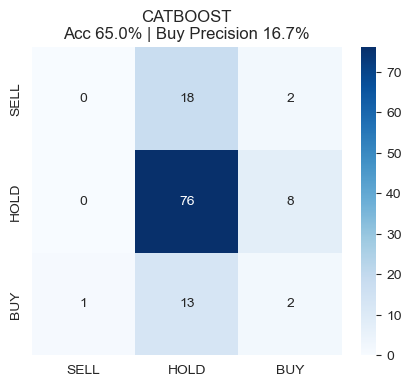


LIGHTGBM
  Accuracy: 68.3%
  Macro F1:  0.353
  Buy Prec:  37.5%
  Buy Rec:   18.8%


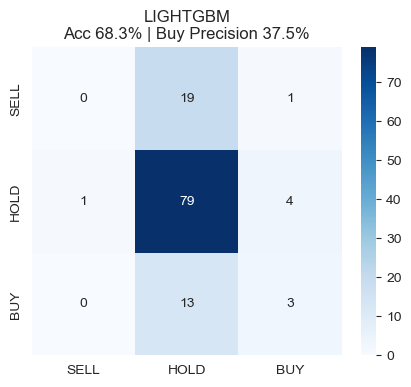


XGBOOST
  Accuracy: 67.5%
  Macro F1:  0.269
  Buy Prec:  0.0%
  Buy Rec:   0.0%


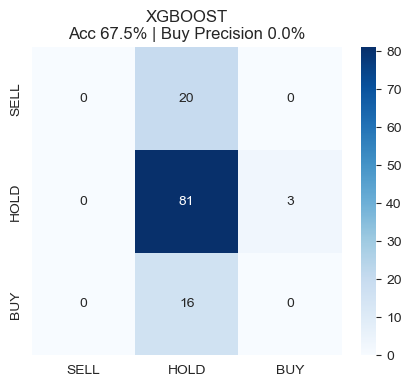


RANDOM_FOREST
  Accuracy: 70.0%
  Macro F1:  0.275
  Buy Prec:  0.0%
  Buy Rec:   0.0%


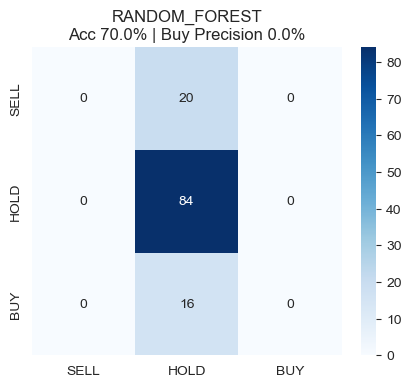


LOGISTIC
  Accuracy: 35.0%
  Macro F1:  0.313
  Buy Prec:  18.4%
  Buy Rec:   43.8%


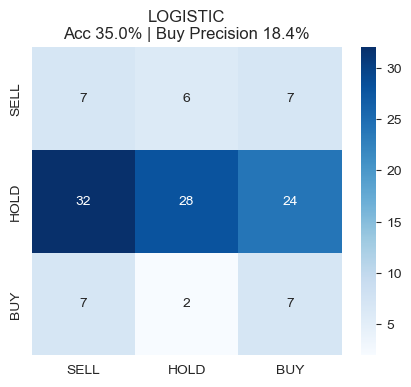

In [41]:
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Verify models exist
print("Models in folder:")
print(os.listdir("../models"))

df = pd.read_csv("../data/processed/btcusdt_final.csv")
df["future_return"] = df["close"].pct_change().shift(-1)
df["label"] = df["future_return"].apply(lambda x: 2 if x > 0.02 else (0 if x < -0.02 else 1))
df = df.dropna().reset_index(drop=True)

FEATURES = ['prev_close','prev_volume','rsi','macd','sma_20','sma_50','sma_200',
            'bb_upper','bb_lower','stoch_k','daily_return','volatility_30d']

X_test = df[FEATURES].iloc[int(len(df)*0.85):]
y_test = df["label"].iloc[int(len(df)*0.85):]

for name in ["catboost", "lightgbm", "xgboost", "random_forest", "logistic"]:
    path = f"../models/{name}.pkl"
    model = joblib.load(path)
    pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, average='macro')
    cm = confusion_matrix(y_test, pred)
    buy_prec = cm[2,2] / (cm[:,2].sum() or 1)
    buy_rec = cm[2,2] / (cm[2,:].sum() or 1)
    
    print(f"\n{name.upper()}")
    print(f"  Accuracy: {acc:.1%}")
    print(f"  Macro F1:  {f1:.3f}")
    print(f"  Buy Prec:  {buy_prec:.1%}")
    print(f"  Buy Rec:   {buy_rec:.1%}")
    
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['SELL','HOLD','BUY'],
                yticklabels=['SELL','HOLD','BUY'])
    plt.title(f"{name.upper()}\nAcc {acc:.1%} | Buy Precision {buy_prec:.1%}")
    plt.show()